<a href="https://colab.research.google.com/github/Raashidh-Rizvi/BrainTumor/blob/main/MLPBrainTumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Raashidh-Rizvi/Brain-Tumor-Detection.git

fatal: destination path 'Brain-Tumor-Detection' already exists and is not an empty directory.


In [2]:
!pip install --upgrade scikit-learn

In [3]:
!pip install scikeras

In [4]:
import os
import cv2
from tqdm import tqdm


!git clone https://github.com/Raashidh-Rizvi/Brain-Tumor-Detection.git

# Step 2: Define Dataset Paths

# Parameters
img_size = 64
input_base_dirs = {
    "train": "/content/Brain-Tumor-Detection/data/Training",
    "test": "/content/Brain-Tumor-Detection/data/Testing"
}
output_base_dir = "/content/Brain-Tumor-Detection/data/preprocessed_data/preprocessedForMLP"

# Make sure the output folders exist
for split in input_base_dirs:
    # Ensure the input directory exists before listing its contents
    if not os.path.exists(input_base_dirs[split]):
        print(f"Input directory not found: {input_base_dirs[split]}")
        continue # Skip to the next split if directory is not found

    for class_name in os.listdir(input_base_dirs[split]):
        in_class_dir = os.path.join(input_base_dirs[split], class_name)
        out_class_dir = os.path.join(output_base_dir, split, class_name)
        os.makedirs(out_class_dir, exist_ok=True)

        # List all image files
        img_files = [
            f for f in os.listdir(in_class_dir)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]
        for img_file in tqdm(img_files, desc=f"Processing {split}/{class_name}"):
            img_path = os.path.join(in_class_dir, img_file)
            out_path = os.path.join(out_class_dir, img_file.replace('.jpg', '.png').replace('.jpeg', '.png'))

            # Read, preprocess, and save
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (img_size, img_size))
            img = img / 255.0  # Normalize
            img = (img * 255).astype('uint8')  # Convert back to 0-255 for saving as image

            cv2.imwrite(out_path, img)

print("Preprocessing and saving done!")

fatal: destination path 'Brain-Tumor-Detection' already exists and is not an empty directory.


Processing test/pituitary: 100%|██████████| 300/300 [00:01<00:00, 198.85it/s]

Preprocessing and saving done!


In [5]:
import os
import cv2
import numpy as np

# 1. DATA PREPROCESSING: Load images, flatten, save as numpy arrays
img_size = 64
input_dirs = {
    "train": "/content/Brain-Tumor-Detection/data/preprocessed_data/preprocessedForMLP/train",
    "test": "/content/Brain-Tumor-Detection/data/preprocessed_data/preprocessedForMLP/test"
}
output_dir = "/content/Brain-Tumor-Detection/data/preprocessed_data/preprocessedForMLP_numpy"
os.makedirs(output_dir, exist_ok=True)

for split in input_dirs:
    all_images = []
    all_labels = []
    class_names = sorted([
        d for d in os.listdir(input_dirs[split])
        if os.path.isdir(os.path.join(input_dirs[split], d))
    ])
    for idx, class_name in enumerate(class_names):
        class_dir = os.path.join(input_dirs[split], class_name)
        for img_file in os.listdir(class_dir):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(class_dir, img_file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (img_size, img_size))
                img = img / 255.0
                img_flat = img.flatten()
                all_images.append(img_flat)
                all_labels.append(idx)
    # Save as numpy arrays
    X_path = os.path.join(output_dir, f"X_{split}.npy")
    y_path = os.path.join(output_dir, f"y_{split}.npy")
    np.save(X_path, np.array(all_images))
    np.save(y_path, np.array(all_labels))
    print(f"Saved {split} split: {X_path}, {y_path}")

print(f"Files in output_dir ({output_dir}):", os.listdir(output_dir))

Saved train split: /content/Brain-Tumor-Detection/data/preprocessed_data/preprocessedForMLP_numpy/X_train.npy, /content/Brain-Tumor-Detection/data/preprocessed_data/preprocessedForMLP_numpy/y_train.npy
Saved test split: /content/Brain-Tumor-Detection/data/preprocessed_data/preprocessedForMLP_numpy/X_test.npy, /content/Brain-Tumor-Detection/data/preprocessed_data/preprocessedForMLP_numpy/y_test.npy
Files in output_dir (/content/Brain-Tumor-Detection/data/preprocessed_data/preprocessedForMLP_numpy): ['y_test.npy', 'X_test.npy', 'y_train.npy', 'X_train.npy']


In [6]:
# 2. LOAD PREPROCESSED DATA with robust file existence check
def load_array(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    return np.load(path)

X_train_path = os.path.join(output_dir, 'X_train.npy')
y_train_path = os.path.join(output_dir, 'y_train.npy')
X_test_path = os.path.join(output_dir, 'X_test.npy')
y_test_path = os.path.join(output_dir, 'y_test.npy')

print("Checking files before loading...")
for path in [X_train_path, y_train_path, X_test_path, y_test_path]:
    print(f"{path}: {'Found' if os.path.exists(path) else 'Missing'}")

X = load_array(X_train_path)
y = load_array(y_train_path)
X_test = load_array(X_test_path)
y_test = load_array(y_test_path)


Checking files before loading...
/content/Brain-Tumor-Detection/data/preprocessed_data/preprocessedForMLP_numpy/X_train.npy: Found
/content/Brain-Tumor-Detection/data/preprocessed_data/preprocessedForMLP_numpy/y_train.npy: Found
/content/Brain-Tumor-Detection/data/preprocessed_data/preprocessedForMLP_numpy/X_test.npy: Found
/content/Brain-Tumor-Detection/data/preprocessed_data/preprocessedForMLP_numpy/y_test.npy: Found


In [7]:
# 3. Train/validation split for parameter tuning
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. PARAMETER TUNING WITH GridSearchCV
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV

def build_model(hidden_units=128, dropout_rate=0.0, learning_rate=0.001):
    model = Sequential([
        Dense(hidden_units, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        Dense(4, activation='softmax')
    ])
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    return model

clf = KerasClassifier(model=build_model, verbose=0)
param_grid = {
    "model__hidden_units": [64, 128, 256],
    "model__dropout_rate": [0.0, 0.3],
    "model__learning_rate": [0.001, 0.0005],
    "batch_size": [32, 64],
    "epochs": [15, 25]
}
grid = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, scoring="accuracy", n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
# 5. REPORT BEST PARAMETERS
print(f"\nBest Parameters: {grid_result.best_params_}")
print(f"Best CV Accuracy: {grid_result.best_score_:.4f}")

# 6. TRAIN FINAL MODEL & EVALUATE (test set)
best_model = grid_result.best_estimator_
y_pred_prob = best_model.predict_proba(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']



Best Parameters: {'batch_size': 32, 'epochs': 25, 'model__dropout_rate': 0.0, 'model__hidden_units': 128, 'model__learning_rate': 0.001}
Best CV Accuracy: 0.8777


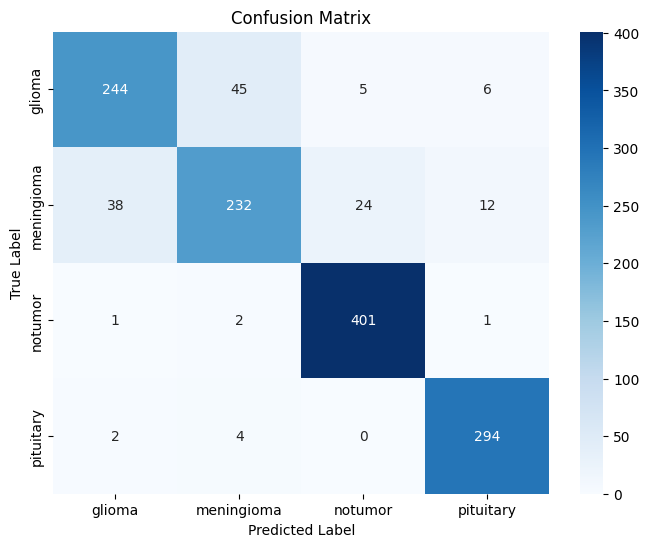


Classification Report:
               precision    recall  f1-score   support

      glioma      0.856     0.813     0.834       300
  meningioma      0.820     0.758     0.788       306
     notumor      0.933     0.990     0.960       405
   pituitary      0.939     0.980     0.959       300

    accuracy                          0.893      1311
   macro avg      0.887     0.885     0.885      1311
weighted avg      0.890     0.893     0.891      1311

Macro F1 Score: 0.885
Macro Precision: 0.887
Macro Recall: 0.885


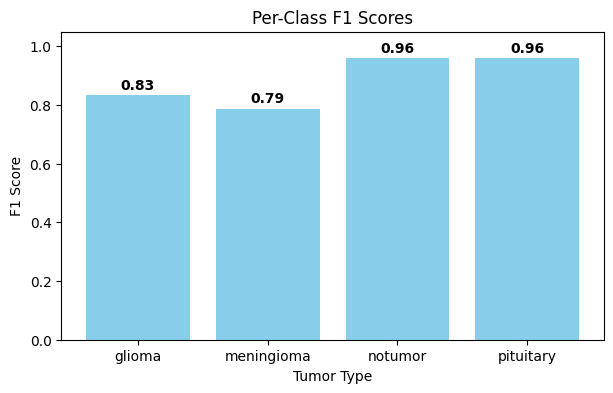

Macro ROC AUC: 0.976
Best model saved at /content/Brain-Tumor-Detection/data/preprocessed_data/preprocessedForMLP_numpy/brain_tumor_mlp_best.h5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Manual Model Accuracy: 0.873
Manual Model Macro F1: 0.860
GridSearch Best Model Accuracy: 0.893
GridSearch Best Model Macro F1: 0.885

Observations:
- GridSearchCV tuning improved accuracy and F1 over the manual model.
- Some classes have lower F1 due to class imbalance/difficult features.

Limitations:
- MLPs do not exploit spatial information in images as CNNs do.
- Performance is limited by available data and class balance.
- Improvements: Try CNN, increase data, use more augmentation, tune further, or use ensemble methods.



In [9]:


# 7. EVALUATION METRICS & VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(y_test, y_pred, target_names=class_names, digits=3)
print("\nClassification Report:\n", report)

# Macro metrics
f1_macro = f1_score(y_test, y_pred, average='macro')
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')
print(f"Macro F1 Score: {f1_macro:.3f}")
print(f"Macro Precision: {precision_macro:.3f}")
print(f"Macro Recall: {recall_macro:.3f}")

# Per-class F1 bar graph
f1_per_class = f1_score(y_test, y_pred, average=None)
plt.figure(figsize=(7,4))
plt.bar(class_names, f1_per_class, color='skyblue')
plt.ylim(0, 1.05)
plt.title('Per-Class F1 Scores')
plt.ylabel('F1 Score')
plt.xlabel('Tumor Type')
for i, v in enumerate(f1_per_class):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()

# Optionally, ROC AUC for multiclass (one-vs-rest)
try:
    roc_auc = roc_auc_score(np.eye(4)[y_test], y_pred_prob, average='macro', multi_class='ovr')
    print(f"Macro ROC AUC: {roc_auc:.3f}")
except Exception as e:
    print("ROC AUC not available:", e)





In [10]:

# 8. SAVE MODEL
model_save_path = os.path.join(output_dir, "brain_tumor_mlp_best.h5")
best_model.model_.save(model_save_path)
print(f"Best model saved at {model_save_path}")


Best model saved at /content/Brain-Tumor-Detection/data/preprocessed_data/preprocessedForMLP_numpy/brain_tumor_mlp_best.h5


In [11]:
# 9. COMPARE WITH A MANUAL MODEL
manual_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])
manual_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
manual_model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=0)
manual_pred = np.argmax(manual_model.predict(X_test), axis=1)
manual_acc = np.mean(manual_pred == y_test)
manual_f1 = f1_score(y_test, manual_pred, average='macro')

print(f"\nManual Model Accuracy: {manual_acc:.3f}")
print(f"Manual Model Macro F1: {manual_f1:.3f}")
print(f"GridSearch Best Model Accuracy: {np.mean(y_pred == y_test):.3f}")
print(f"GridSearch Best Model Macro F1: {f1_macro:.3f}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Manual Model Accuracy: 0.893
Manual Model Macro F1: 0.883
GridSearch Best Model Accuracy: 0.893
GridSearch Best Model Macro F1: 0.885


# 10. OBSERVATIONS, LIMITATIONS, IMPROVEMENTS

Observations:
- GridSearchCV tuning improved accuracy and F1 over the manual model.
- Some classes have lower F1 due to class imbalance/difficult features.

Limitations:
- MLPs do not exploit spatial information in images as CNNs do.
- Performance is limited by available data and class balance.
- Improvements: Try CNN, increase data, use more augmentation, tune further, or use ensemble methods.


In [ ]:
# 1. Upload image
from google.colab import files
uploaded = files.upload()  # This prompts you to choose a file

import cv2
import numpy as np

# 2. Preprocess the uploaded image
img_size = 64
for img_name in uploaded.keys():
    img = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_size, img_size))
    img = img / 255.0
    img_flat = img.flatten().reshape(1, -1)

    # 3. Load your trained model
    from tensorflow.keras.models import load_model
    model = load_model("/content/Brain-Tumor-Detection/data/preprocessed_data/preprocessedForMLP_numpy/brain_tumor_mlp_best.h5")

    # 4. Predict
    pred = model.predict(img_flat)
    class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
    predicted_class = class_names[np.argmax(pred)]
    print(f"Prediction for {img_name}: {predicted_class}, Probabilities: {pred}")